In [ ]:
what_are_we_covering = {1: "data (prepare and load)",
                    2: "build model",
                    3: "fitting the model to data",
                    4: "evaluating model",
                    5: "saving and loading the model",
                    6: "putting it all together"}

# First Neural Network Model

In [ ]:
import torch
from torch import nn # neural network graphs

torch.__version__

'2.1.0+cu118'

In [ ]:
# Create known parameters for linear function
a = 0.7
b = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start,end,step)
X_original = torch.arange(start,end,step)

X[:10], y[:10], X_original[:10]

(tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000, 0.1200, 0.1400, 0.1600,
         0.1800]),
 tensor([0.3000, 0.3140, 0.3280, 0.3420, 0.3560, 0.3700, 0.3840, 0.3980, 0.4120,
         0.4260]),
 tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000, 0.1200, 0.1400, 0.1600,
         0.1800]))

In [ ]:
train_split = int(0.8 * len(X)) # make 80%

X_train, y_train = X[:train_split], y[:train_split] # make train dataset for x and y 80%
X_test, y_test = X[train_split:], y[train_split:] # make test dataset for x and y 20%

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [ ]:
import matplotlib.pyplot as plt

def plt_predictions(train_data : torch.Tensor = X_train,
                     train_labels : torch.Tensor = y_train,
                     test_data : torch.Tensor = X_test,
                     test_labels : torch.Tensor = y_test,
                     predictions : torch.Tensor = None):
  """
  Plots training data, test data and compares predictions.

  """
  plt.figure(figsize=(10,7)) # Size of a plot

  plt.scatter(train_data, train_labels, c = "b", s = 4, label = "Training data") # Draw data points from our tensor, plotting them with x and y coordinates

  plt.scatter(test_data, test_labels, c = "g", s = 4, label = "Testing data")


  if predictions is not None:
    plt.scatter(test_data,predictions, c="r", s=4, label="Predictions")

  plt.legend(prop={"size": 10})

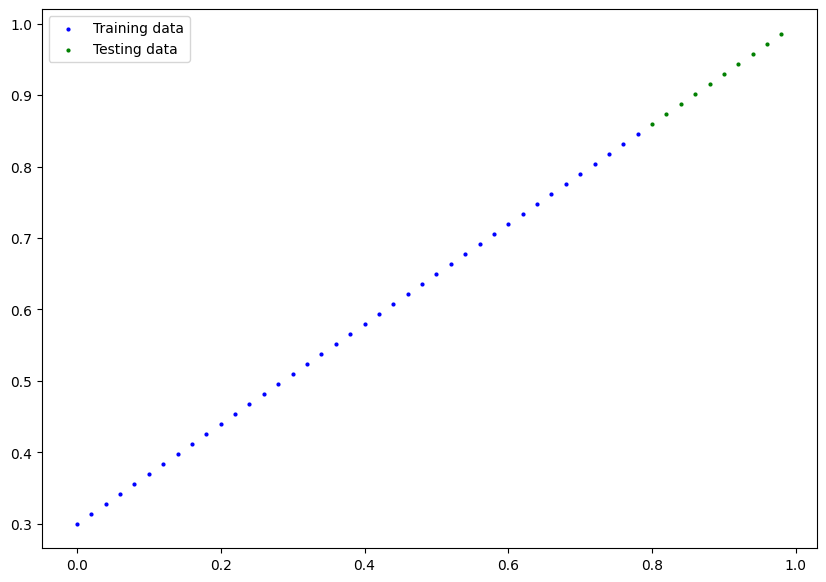

In [ ]:
plt_predictions() # we can use it without parameters because a default one are same as ours

# 1. Model


In [ ]:
# Create linear regression model class
class LinearRegressionModule(nn.Module): # <- Everything in PyTorch inherits from nn.Module
  def __init__(self):
    super().__init__()
#    self.layer_1 = nn.Linear(2, 8)
#    self.layer_2 = nn.Linear(8, 8)
#    self.layer_3 = nn.Linear(8, 1)
    self.layers = nn.Sequential(
        nn.Linear(10, 10),
        nn.Linear(10, 10),
        nn.Linear(10, 1)
    )
    # Forward method to define the computation in the model
  def forward(self, x: torch.Tensor) -> torch.Tensor:# <- We need to overwrite this method
    return  self.layers(x)  #self.layer_3(self.layer_2(self.layer_1(x)))

In [ ]:
torch.manual_seed(42) # This sets a random seed, ensuring that random functions produce the same results every time, which is useful for reproducibility.

# Create an instance of the model

model_0 = LinearRegressionModule()
model_0

LinearRegressionModule(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Linear(in_features=10, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

# Making Predictions

In [ ]:
X_test.shape
X_train.shape

torch.Size([40])

In [ ]:
# Make predictions with models

with torch.inference_mode(): #<- this is lot faster if we dont need gradient
  y_preds = model_0(X_test)

y_preds

tensor([-0.0778])

ValueError: ignored

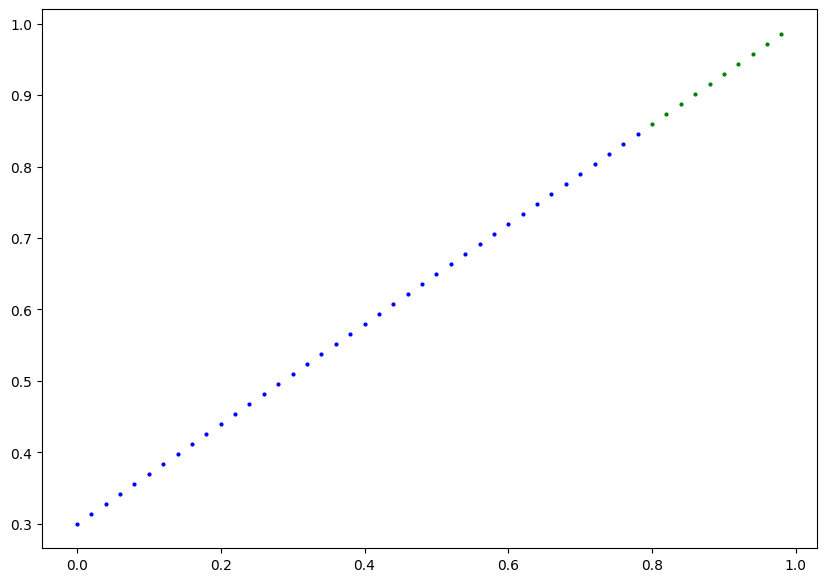

In [ ]:
plt_predictions(predictions=y_preds)

# Learning


In [ ]:
# We need to use loss function
loss_fn = nn.MSELoss()


#Setup an optimizer
optimizer = torch.optim.Adam(params = model_0.parameters(),
                            lr = 0.01)

### Building a training loop (and testing)

0. Loop through the data

1. Forward pass goes through model

2. Calculate the loss

3. Optimize

4. Loss backward like a reverse engeneering

5. Optimizer step - Gradient descent

In [ ]:
torch.manual_seed(42)

epochs = 1500

epoch_count = []
loss_values = []
test_loss_values = []


for epoch in range(epochs):

  ### Training
  model_0.train()

  # 1. Forward pass = push data through model
  y_pred = model_0(X_train)

  # 2. Loss
  loss = loss_fn(y_pred, y_train)

  # 3. optimizer
  optimizer.zero_grad() # <-- now I got it. It means that it zeros the gradient that existed before because otherwise the gradient would be a combination of the old and new gradient, which would have already been used to update your model parameters

  # 4. backpropagation
  loss.backward() # <-- updating the Weights and biases based on the calculated gradient

  #5. Step optimizer
  optimizer.step() # <-- optimize loss using the specified learning rate



  ### Testing
  model_0.eval() #<- turns off different settings

  with torch.inference_mode():
    # 1. Forward pass
    test_preds = model_0(X_test)

    # 2. Calculate the loss
    test_loss = loss_fn(test_preds, y_test)


  epoch_count.append(epoch)
  loss_values.append(loss)
  test_loss_values.append(test_loss)

  print(f"Epoch: {epoch + 1} | Loss: {loss} | Test loss: {test_loss}")

In [ ]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

In [ ]:
plt.plot(epoch_count, torch.tensor(test_loss_values).cpu().numpy(), label = "test loss") # The plot function expects NumPy arrays on the CPU, so we convert the PyTorch tensor to a NumPy array on the CPU using `torch.tensor(test_loss_values).cpu().numpy()`.
plt.plot(epoch_count, torch.tensor(loss_values).cpu().numpy(), label = "train loss")
plt.title("training") # title
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

In [ ]:
plt_predictions(predictions=y_preds), plt_predictions(predictions=y_preds_new)


## Saving models in PyTorch

1. torch.save() - save PyTorch project to pytohon pickle format
2. torch.load() - load project
3. torch.nn.Module.load_state_dic() - this allowes saves your models in state dic

In [ ]:
# Saving our PyTorch module
from pathlib import Path

model_path = Path("models") # Define the directory path
model_path.mkdir(parents = True, exist_ok = True) # Create the directory if it doesn't exist

model_name = "01_PyTorch_workflow_model_0.pth"
model_save_path = model_path / model_name # Path to the file

torch.save(model_0.state_dict(), model_save_path) # Save the model's state dictionary to the specified path

In [ ]:
torch.load(model_save_path) # Load the saved model's state dictionary

In [ ]:
model_0.state_dict() # Display the current model's state dictionary

In [ ]:
loaded_model_0 = LinearRegressionModule() # When loading a model, we load its parameters, but we also need to re-instantiate the model's structure first.

loaded_model_0.load_state_dict(torch.load(model_save_path)) # Now, load the saved parameters into the model's structure.

In [ ]:
loaded_model_0.state_dict() # Display the loaded model's state dictionary

In [ ]:
# How to make predictions
loaded_model_0.eval()
with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

y_preds_new == loaded_model_preds # Compare the predictions from the original model and the loaded model.